In [0]:
import pandas as pd
import string
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [0]:
!pip install -q gensim

In [3]:
# Download WordNet and stopwords
nltk.download('wordnet');
nltk.download('stopwords');

# Download data
DATA_LINK = "http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip"
FILE_NAME = 'cornell_movie_dialogs_corpus.zip'
!test -f $FILE_NAME || (wget -q $DATA_LINK && unzip -q $FILE_NAME && rm -rf $FILE_NAME)

# Read data
data_folder = "./cornell movie-dialogs corpus"
with open('{}/movie_lines.txt'.format(data_folder), 'rb') as movie_lines_file:
    lines_data = movie_lines_file.read().decode(encoding='utf-8', errors='ignore')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Data Gathering

<b>1.</b> First, we split text by endline symbol (`\n`) to get list of utterances.

In [4]:
utterances = lines_data.split(sep='\n')
print('Last line ("{}") is an empty string, so we remove it from list of utterances.'.format(utterances.pop()))
print('Number of utterances:', len(utterances))

Last line ("") is an empty string, so we remove it from list of utterances.
Number of utterances: 304713


<b>2.</b> Observations on first 10 samples suggest the string ` +++$+++ ` acts as seperator between 5 components of an utterance.

In [5]:
print('> First 10 samples:')
print(*utterances[:10], sep='\n')

print()

print('> Is there a line which does not have exactly 4 "+++$+++"?')
print('- {}'.format(any([line.count(' +++$+++ ') != 4 for line in utterances])))

> First 10 samples:
L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!
L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!
L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.
L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?
L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go.
L924 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ Wow
L872 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Okay -- you're gonna need to learn how to lie.
L871 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ No
L870 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I'm kidding.  You know how sometimes you just become this "persona"?  And you don't know how to quit?
L869 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Like my fear of wearing pastels?

> Is there a line which does not have exactly 4 "+++$+++"?
- False


<b>3.</b> We then split each utterance by the seperator and convert the whole list to dataframe. Each column in dataframe is renamed regarding its meanings provided in `README.txt`.

In [0]:
utterances_data = pd.DataFrame([line.split(' +++$+++ ') for line in utterances],
                               columns=['lineID', 'characterID', 'movieID', 'chacterter_name', 'text'])

In [7]:
print('Number of characters:', utterances_data['characterID'].nunique())
print('Number of movies:', utterances_data['movieID'].nunique())
print()
utterances_data.sample(5)

Number of characters: 9035
Number of movies: 617



,lineID,characterID,movieID,chacterter_name,text
181585,L213256,u5269,m348,TYLER,"People think that you're me, because you and I..."
279294,L586910,u8262,m561,JOHANA,"Listen, I just found out we've got real proble..."
299235,L648155,u8867,m601,NORMAN,Ohmigod. You'll never believe...I saw Schumwa...
55922,L317639,u1639,m107,RIZZO,"No, you're dead! You're all dead!"
280945,L597203,u8300,m564,LOMBARD,Id appreciate it if I could use your phone.


### Data Cleaning

<b>1.</b> We define normal characters consisting of alphabetic letters and basic sentence punctuations. Others are considered as special characters.

In [8]:
characters = set()
utterances_data['text'].apply(lambda text : characters.update(list(text)));

# Set of special characters is the intersection
# between set of letters appeared in the dataset and normal characters
special_characters = characters.difference(string.ascii_letters + '.,!? \'')    

print('List of {} special characters:'.format(len(special_characters)))
print(*special_characters, sep=', ')

List of 35 special characters:
], <, 2, 4, 9, 3, -, |, 8, 6, 5, /, ", 	, _, 7, &, [, *, ), ^, =, %, :, }, $, {, ~, #, 0, `, ;, 1, >, +


<b>2.</b> Remove special characters and replace punctuations as well as verb short form ('m, 's, 've, 'd, 're, 'll) by space.

In [9]:
def preprocess(text):
  text = ''.join([c for c in text if c not in special_characters])
  text = re.sub("'m|'s|'ve|'d|'re|'ll|([\.,])+", ' ', text)
  return text

sample_text = utterances_data['text'].sample().values[0]
print('Sample text:', sample_text)
print('After preprocessed:', preprocess(sample_text))

Sample text: But it's light in there now.
After preprocessed: But it  light in there now 


<b>3.</b> Lower casing, lemmatization and repeat removing are utilized to normalize utterance tokens.

In [10]:
from nltk.corpus import wordnet

# Create a simple RepeatReplacer using regex
class RepeatReplacer():
    def __init__(self):
        self.pattern = re.compile(r'(\w*)(\w)\2(\w*)')
        self.repl = r'\1\2\3'
    
    def replace(self, word):
        if wordnet.synsets(word):
            return word
        repl_word = self.pattern.sub(self.repl, word)
        
        # Recursively replace until it can't be replaced anymore
        return repl_word if repl_word == word else self.replace(repl_word)

# Testing RepeatReplacer object
RepeatReplacer().replace('aaaaaaaaaaaaaaarghhhh')

'argh'

In [11]:
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

replacer = RepeatReplacer()
#stemmer = SnowballStemmer(language='english')
lemmatizer = WordNetLemmatizer()

tokenize = lambda text : [lemmatizer.lemmatize(replacer.replace(
                          word.strip(string.punctuation)))
                          for word in text.lower().split() if word and word not in stop_words]

sample_text = utterances_data['text'].sample().values[0]
print('Sample text:', sample_text)
print('After tokenized:', tokenize(sample_text))

Sample text: Hi.
After tokenized: ['hi']


### Word Embedding

In [0]:
text_data = utterances_data['text'].apply(lambda text : tokenize(preprocess(text)))

In [13]:
words = set()
text_data.apply(words.update)
print('Number of distinct words:', len(words))

Number of distinct words: 50755


#### Bag of Words

In [14]:
# Naive BoW
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer()
bow_vec = count_vectorizer.fit_transform(utterances_data['text'].values)

print('Shape:', bow_vec.shape)
print(*bow_vec[0].toarray())

Shape: (304713, 49103)
[0 0 0 ... 0 0 0]


In [15]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_vec = tfidf_vectorizer.fit_transform(utterances_data['text'].values)

print('Shape:', tfidf_vec.shape)
print(*tfidf_vec[0].toarray())

Shape: (304713, 49103)
[0. 0. 0. ... 0. 0. 0.]


#### CBOW

In [0]:
# Ref: https://towardsdatascience.com/word-embedding-with-word2vec-and-fasttext-a209c1d3e12c

from gensim.models.word2vec import Word2Vec
cbow = Word2Vec(sentences=text_data, window=5, size=100, sg=0)
cbow_words = list(cbow.wv.vocab.keys())
cbow_embeddings = cbow.wv[cbow.wv.vocab]

#### Skip Gram

In [0]:
from gensim.models.word2vec import Word2Vec
skipgram = Word2Vec(sentences=text_data, window=5, size=100, sg=1)
skipgram_words = list(skipgram.wv.vocab.keys())
skipgram_embeddings = skipgram.wv[skipgram.wv.vocab]

### GloVe

In [0]:
# Ref: https://medium.com/@jonathan_hui/nlp-word-embedding-glove-5e7f523999f6



### Quanlitative Testing

In [0]:
def visualize(words, embeddings, n_samples='all'):
  if n_samples == 'all':
    labels = words
    positions = embeddings
  else:
    indices = np.random.randint(0, len(words), n_samples)
    labels = [words[i] for i in indices]
    positions = [embeddings[i] for i in indices]

  positions = TSNE(n_components=2).fit_transform(positions)
  plt.figure(figsize=(15, 7))
  plt.scatter(positions[:, 0], positions[:, 1], c='purple', alpha=.5);

  for label, x, y in zip(labels, positions[:, 0], positions[:, 1]):
    plt.annotate(label, (x, y))

  plt.show()  

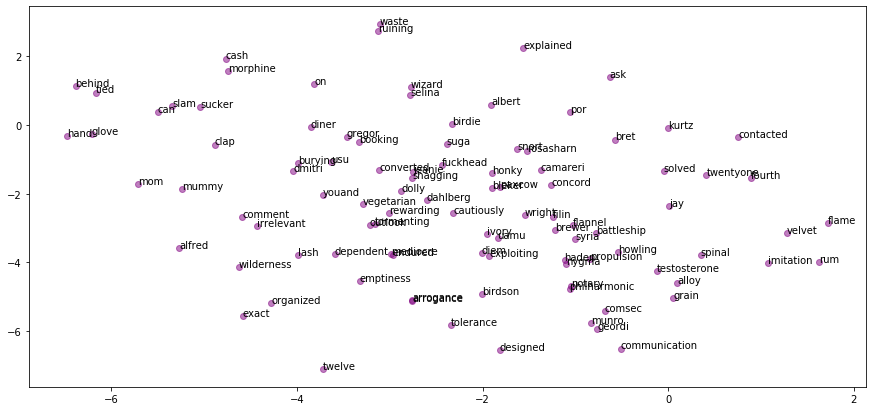

In [76]:
visualize(skipgram_words, skipgram_embeddings, n_samples=100)